In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc

from jaxbo.models import MultifidelityGP
from jaxbo.utils import normalize_MultifidelityGP, compute_w_gmm
from jaxbo.test_functions import *

onp.random.seed(1234)

In [2]:
# Define test function
f, p_x, dim, lb, ub = forrester()
f_L, f_H = f

# Problem setttings
NL = 15
NH = 1
noiseL = 0.0
noiseH = 0.0
options = {'kernel': 'RBF',
           'criterion': 'LW-LCB', 
           'input_prior': p_x,
           'kappa': 2.0,
           'nIter': 4}
gp_model = MultifidelityGP(options)

# Fetch domain bounds
bounds = {'lb': lb, 'ub': ub}

# Initial training data
XL = lb + (ub-lb)*lhs(dim, NL)
yL = vmap(f_L)(XL)
yL = yL + noiseL*yL.std(0)*onp.random.normal(yL.shape)

XH = lb + (ub-lb)*lhs(dim, NH)
yH = vmap(f_H)(XH)
yH = yH + noiseH*yH.std(0)*onp.random.normal(yH.shape)

y = np.concatenate([yL, yH])

# Test data
if dim == 1:
    create_plots = True
    nn = 1000
    X_star = np.linspace(lb[0], ub[0], nn)[:,None]
    yL_star = vmap(f_L)(X_star)
    yH_star = vmap(f_H)(X_star)
elif dim == 2:
    create_plots = True
    nn = 80
    xx = np.linspace(lb[0], ub[0], nn)
    yy = np.linspace(lb[1], ub[1], nn)
    XX, YY = np.meshgrid(xx, yy)
    X_star = np.concatenate([XX.flatten()[:,None], 
                             YY.flatten()[:,None]], axis = 1)
    yL_star = vmap(f_L)(X_star)
    yH_star = vmap(f_H)(X_star)
else:
    create_plots = False
    nn = 20000
    X_star = lb + (ub-lb)*lhs(dim, nn)
    yL_star = vmap(f_L)(X_star)
    yH_star = vmap(f_H)(X_star)

# True location of global minimum
idx_true = np.argmin(yH_star)
true_x = X_star[idx_true,:]
true_y = yH_star.min()
dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
result = minimize(f_H, true_x, jac=None, method='L-BFGS-B', bounds = dom_bounds)
true_x, true_y = result.x, result.fun

In [4]:
# Main Bayesian optimization loop
rng_key = random.PRNGKey(0)
for it in range(options['nIter']):
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, options['nIter']))
    print('-------------------------------------------------------------------')

    # Fetch normalized training data
    norm_batch, norm_const = normalize_MultifidelityGP(XL, yL, XH, yH, bounds)

    # Train GP model
    print('Train GP...')
    rng_key = random.split(rng_key)[0]
    opt_params = gp_model.train(norm_batch,
                                rng_key,
                                num_restarts = 10)

    # Fit GMM
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        print('Fit GMM...')
        rng_key = random.split(rng_key)[0]
        kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': bounds,
                  'rng_key': rng_key}
        gmm_vars = gp_model.fit_gmm(**kwargs, N_samples = 10000)
    else:
        gmm_vars = None

    # Compute next point via minimizing the acquisition function
    print('Computing next acquisition point...')
    kwargs = {'params': opt_params,
              'batch': norm_batch,
              'norm_const': norm_const,
              'bounds': bounds,
              'kappa': options['kappa'],
              'gmm_vars': gmm_vars,
              'rng_key': rng_key}
    new_X,_,_ = gp_model.compute_next_point_lbfgs(num_restarts=10, **kwargs)

    # Acquire data
    new_y = vmap(f_H)(new_X)
    new_y = new_y + noiseH*new_y.std(0)*onp.random.normal(new_y.shape)

    # Augment training data
    print('Updating data-set...')
    XH = np.concatenate([XH, new_X], axis = 0)
    yH = np.concatenate([yH, new_y], axis = 0)

    # Print current best
    idx_best = np.argmin(yH)
    best_x = XH[idx_best,:]
    best_y = yH.min()
    print('True location: ({}), True value: {}'.format(true_x, true_y))
    print('Best location: ({}), Best value: {}'.format(best_x, best_y))
    print('New  location: ({}), New  value: {}'.format(new_X, new_y))

-------------------------------------------------------------------
------------------------- Iteration 1/4 -------------------------
-------------------------------------------------------------------
Train GP...
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: ([0.75724875]), True value: -6.020740055767067
Best location: ([0.45272981]), Best value: 0.5083170107522462
New  location: ([[1.]]), New  value: [15.82973195]
-------------------------------------------------------------------
------------------------- Iteration 2/4 -------------------------
-------------------------------------------------------------------
Train GP...
Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: ([0.75724875]), True value: -6.020740055767067
Best location: ([0.09196226]), Best value: -0.5090123862031162
New  location: ([[0.09196226]]), New  value: [-0.50901239]
-------------------------------------------------------------------
---------

In [7]:
print(new_X)

[[0.75727863]]


In [5]:
# Test accuracy
mean, std = gp_model.predict(X_star, **kwargs)
mean = mean * norm_const['sigma_y'] + norm_const['mu_y']
std = std * norm_const['sigma_y']
lower = mean - 2.0*std
upper = mean + 2.0*std
# Check accuracy
error = np.linalg.norm(mean-yH_star,2)/np.linalg.norm(yH_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 2.778428e-03


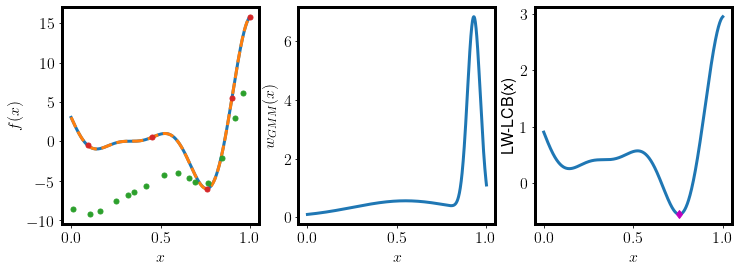

In [6]:
if create_plots:
    # Compute predictions
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        w_pred = compute_w_gmm(X_star, **kwargs)
    else:
        w_pred = np.zeros(X_star.shape[0])
        
    acq_fun = lambda x: gp_model.acquisition(x, **kwargs)
    a_pred = vmap(acq_fun)(X_star)
    x_new,_,_ = gp_model.compute_next_point_lbfgs(num_restarts=10, **kwargs)
    a_val = vmap(acq_fun)(x_new)

    # Convert to NumPy
    X_star = onp.array(X_star)
    yH_star = onp.array(yH_star)
    mean = onp.array(mean)
    std = onp.array(std)
    w_pred = onp.array(w_pred)
    a_pred = onp.array(a_pred)
    
    # Plot
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['axes.linewidth']=3
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    rc('text', usetex=True)

    plt.figure(figsize = (12,4))
    plt.subplot(1, 3, 1)
    plt.plot(X_star, yH_star, lw = 3)
    plt.plot(X_star, mean, '--', lw = 3)
    plt.plot(XL, yL, '.', ms = 10)
    plt.plot(XH, yH, '.', ms = 10)
    plt.fill_between(X_star.flatten(), lower, upper, 
                     facecolor='orange', alpha=0.5, label="Two std band")
    plt.xlabel(r'$x$')
    plt.ylabel(r'$f(x)$')

    plt.subplot(1, 3, 2)
    plt.plot(X_star, w_pred, lw = 3)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$w_{GMM}(x)$')

    plt.subplot(1, 3, 3)
    plt.plot(X_star, a_pred, lw = 3)
    plt.plot(x_new, a_val, 'md') 
    plt.xlabel(r'$x$')
    plt.ylabel(r'%s(x)' % (options['criterion']))